<a href="https://colab.research.google.com/github/ulyazzh/NaturalLanguageProcessing/blob/main/News/NLP_NEWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

#untuk pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#untuk modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#word embedding
import gensim
from gensim.models import Word2Vec


In [ ]:
#membaca dataset
df_train= pd.read_csv('Data_Train.csv', encoding='latin-1')
df_test=pd.read_csv('Data_Test.csv', encoding='latin-1')

In [ ]:
#menampilkan dataset
df_train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ...",1
4,"In global markets, gold prices edged up today ...",3


# **EXPLORATORY DATA ANALYSIS (EDA)**

SECTION
1    2772
2    1924
0    1686
3    1246
Name: count, dtype: int64


<Axes: xlabel='SECTION', ylabel='count'>

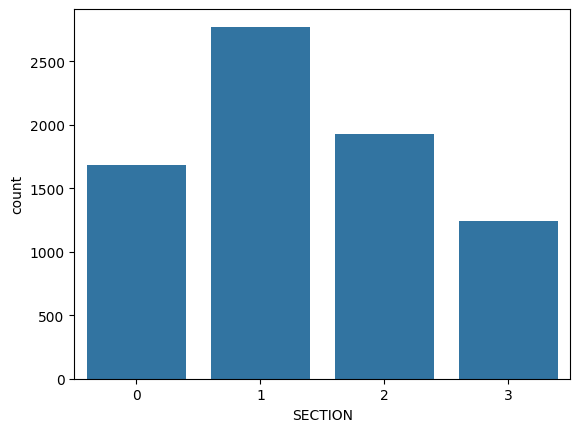

In [ ]:
#Menghitung distribusi jumlah berita di setiap kategori
import seaborn as sns

x = df_train['SECTION'].value_counts()
print(x)
sns.barplot(x=x.index, y=x)

*   SECTION 0: 1686 berita
*   SECTION 1: 2772 berita
*   SECTION 2: 1924 berita
*   SECTION 3: 1246 berita

In [ ]:
df_train.isnull().sum()

,0
STORY,0
SECTION,0


In [ ]:
# WORD-COUNT
df_train['word_count'] = df_train['STORY'].apply(lambda x: len(str(x).split()))

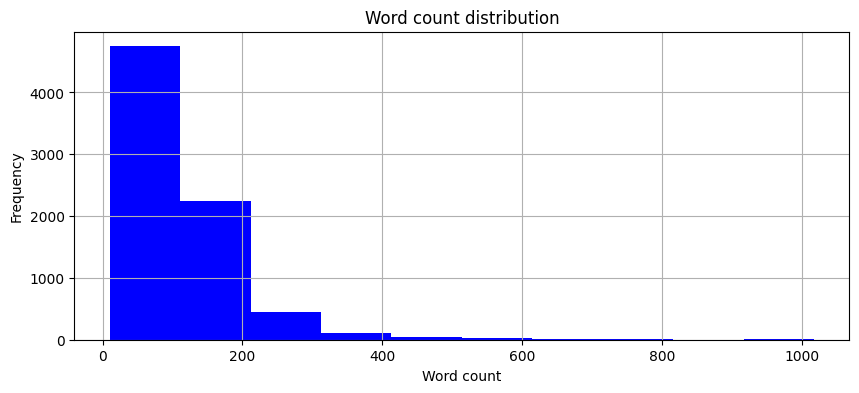

In [ ]:
# PLOTTING WORD-COUNT
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
df_train['word_count'].hist(ax=ax, color='blue')
ax.set_title('Word count distribution')
ax.set_xlabel('Word count')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['STORY'].apply(lambda x: len(str(x)))

**TEXT PRE-PROCESSING**

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

In [ ]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [ ]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['STORY'].apply(lambda x: finalpreprocess(x))
df_train.head()

,STORY,SECTION,word_count,char_count,clean_text
0,But the most painful was the huge reversal in ...,3,148,843,painful huge reversal fee income unheard among...
1,How formidable is the opposition alliance amon...,0,17,129,formidable opposition alliance among congress ...
2,Most Asian currencies were trading lower today...,3,58,386,asian currency trade low today south korean ch...
3,"If you want to answer any question, click on ...",1,103,587,want answer question click answer click answer...
4,"In global markets, gold prices edged up today ...",3,46,299,global market gold price edge today disappoint...


**vectorization**

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["SECTION"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [ ]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

#building Word2Vec model
# Word2Vec runs on tokenized sentences, X_train_tok and X_test_tok are already created
model = Word2Vec(X_train_tok, min_count=1)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        if word2vec:
            self.dim = len(next(iter(word2vec.values())))
        else:
            self.dim = 0

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       361
           1       0.98      0.98      0.98       562
           2       0.95      0.99      0.97       363
           3       0.98      0.97      0.97       240

    accuracy                           0.97      1526
   macro avg       0.97      0.97      0.97      1526
weighted avg       0.97      0.97      0.97      1526

Confusion Matrix: [[338   6  16   1]
 [  5 550   3   4]
 [  4   0 359   0]
 [  1   6   0 233]]


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
#y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1] # Removed as it's not needed for metrics
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

# Removed ROC curve and AUC calculation as they are for binary classification
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       361
           1       0.94      0.95      0.95       562
           2       0.91      0.94      0.93       363
           3       0.95      0.91      0.93       240

    accuracy                           0.93      1526
   macro avg       0.93      0.93      0.93      1526
weighted avg       0.93      0.93      0.93      1526

Confusion Matrix: [[328  11  18   4]
 [  7 536  12   7]
 [ 13   9 340   1]
 [  4  16   2 218]]


In [ ]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       361
           1       0.89      0.99      0.94       562
           2       0.99      0.90      0.94       363
           3       1.00      0.89      0.94       240

    accuracy                           0.94      1526
   macro avg       0.96      0.93      0.94      1526
weighted avg       0.95      0.94      0.94      1526

Confusion Matrix: [[343  16   2   0]
 [  2 558   2   0]
 [ 12  26 325   0]
 [  1  25   0 214]]


In [ ]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['STORY'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text']
#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
#use the best model to predict 'target' value for the new dataset
y_predict = lr_tfidf.predict(X_vector)
df_test['target']= y_predict
print(df_test.head())

                                               STORY  \
0  2019 will see gadgets like gaming smartphones ...   
1  It has also unleashed a wave of changes in the...   
2  It can be confusing to pick the right smartpho...   
3  The mobile application is integrated with a da...   
4  We have rounded up some of the gadgets that sh...   

                                          clean_text  target  
0  see gadget like game smartphones wearable medi...       1  
1  also unleashed wave change mcu make sure futur...       2  
2  confuse pick right smartphone segregate top sm...       1  
3  mobile application integrate dashboard confirm...       1  
4  round gadget show left indelible mark consumer...       1  
